In [5]:
"""
Simple example of using swmm to model a culvert

We are coupling via weir and orifice equation 
(checkout coupling module)

To control oscilations we seem to need small routing_step
set in swmm_input_long_culvert.inp and smoothing of the calculated
Q. At present step to 10secs"""


#------------------------------------------------------------------------------
print('ABOUT to Start Simulation: IMPORT NECESSARY MODULES')
#------------------------------------------------------------------------------

import anuga
import numpy as np
from hymo import SWMMInpFile

from pyswmm import Simulation, Nodes, Links
import matplotlib.pyplot as plt
import pandas as pd
from pyswmm import SystemStats
import matplotlib
from coupling import calculate_Q
from coupling_functions.coupling import calculate_Q_v2



#------------------------------------------------------------------------------
print('SETUP FILENAMES, MODEL DOMAIN and VARIABLES')
#------------------------------------------------------------------------------
# outname =  'swmm_input_long_culvert_1cms'

outname =  'swmm_input_long_culvert_3inlets'


inp_name = outname + '.inp'
basename = 'simple_culvert_3inlets'
inp = SWMMInpFile(inp_name)
plt.style.use('ggplot')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 10})

baseline_flow  = inp.inflows.Baseline.values[0]
baseline_flow2 = inp.inflows.Baseline.values[1]

# baseline_flow = 0.1
# input_Q = 0

rf = 20  # refinement factor for domain, if too coarse the inlets will overlap the wall

dt = 0.2     # yield step
out_dt = 2.0 # output step
ft = 600     # final timestep

# slow the response of the coupling calculation
time_average = 10 # sec
cw = 0.6
co = 0.6

verbose   = False
visualise = True

domain = anuga.rectangular_cross_domain(3*rf, rf, len1=60, len2=20)

domain.set_minimum_storable_height(0.0001) 
domain.set_name(outname) 
print (domain.statistics())

def topography(x,y):

    z = 5*np.ones_like(x)

    channel = np.logical_and(y>5,y<15)

    z = np.where(channel, x/100, z)

    # z = np.where(np.logical_and(channel,x<10), x/300, z)
    # z = np.where(np.logical_and(channel,(x>=12) & (x<22)), x/300, z)
    # z = np.where(np.logical_and(channel,(x>=22) & (x<42)), x/300, z)
    # #z = np.where(np.logical_and(channel,x>20), x/300, z)
    # z = np.where(np.logical_and(channel,x>50), x/300, z)
    
    return z

domain.set_quantity('elevation', topography, location='centroids')

domain.set_quantity('friction', 0.035)

#------------------------------------------------------------------------------
print('SETUP ANUGA INFLOW Inlet_operator')
#------------------------------------------------------------------------------

line=[[59.0, 5.0],[59.0, 15.0]]

#------------------------------------------------------------------------------
print('SETUP BOUNDARY CONDITIONS')
#------------------------------------------------------------------------------

print ('Available boundary tags', domain.get_boundary_tags())

Br = anuga.Reflective_boundary(domain)
Bd = anuga.Dirichlet_boundary([-1.0,0,0])
# Bd = anuga.Dirichlet_boundary([0,10,10])
# Bd2 = anuga.Dirichlet_boundary([5.5,0,0])

domain.set_boundary({'left': Bd, 'bottom': Bd, 'top': Bd, 'right': Bd})
# domain.set_boundary({'left': Br, 'bottom': Br, 'top': Br, 'right': Br})

#------------------------------------------------------------------------------
print('SETUP ANUGA Inlet_operators to support coupling with stormwater system')
#------------------------------------------------------------------------------

# inlets across full channel. Make sure to set the culvert in the swmm_simple_long_culvert.inp to a value of 
# cw = 8
# small inlets in centre of channel. Make sure to set the culvert in the swmm_simple_long_culvert.inp to a value of 
cw = 8.0




inlet_polygon = [[50.0, 10-cw/2], [52.0, 10-cw/2], [52.0, 10+cw/2], [50.0, 10+cw/2]]
inlet1_anuga_region = anuga.Region(domain, polygon=inlet_polygon)

inlet2_polygon = [[40.0, 10-cw/2], [42.0, 10-cw/2], [42.0, 10+cw/2], [40.0, 10+cw/2]]
inlet2_anuga_region = anuga.Region(domain, polygon=inlet_polygon)

inlet3_polygon = [[20.0, 10-cw/2], [22.0, 10-cw/2], [22.0, 10+cw/2], [20.0, 10+cw/2]]
inlet3_anuga_region = anuga.Region(domain, polygon=inlet_polygon)

outlet_polygon = [[8.0, 10-cw/2], [10.0, 10-cw/2], [10.0, 10+cw/2], [8.0, 10+cw/2]]
outlet_anuga_region = anuga.Region(domain, polygon=outlet_polygon)

outfall_polygon = [[1.0, 10-cw/2], [2.0, 10-cw/2], [2.0, 10+cw/2], [1.0, 10+cw/2]]
outfall_anuga_region = anuga.Region(domain, polygon=outfall_polygon)



if baseline_flow == 0:
    baseline_flow = 0.5
    rain_polygon = [[50.0, 10-cw/2], [52.0, 10-cw/2], [52.0, 10+cw/2], [50.0, 10+cw/2]]
    inlet1_rain_region = anuga.Region(domain, polygon=rain_polygon)
    rain_anuga_inlet_op   = anuga.Inlet_operator(domain, outlet_anuga_region, Q = baseline_flow, zero_velocity=False)





anuga_length_weirs = np.array(4 * [2*cw])
anuga_area_manholes = np.array(4 * [2*cw])


# now setup anuga Inlet_operators to remove or add water from anuga domain.
inlet1_anuga_inlet_op = anuga.Inlet_operator(domain, inlet1_anuga_region, Q=0.0, zero_velocity=False)
inlet2_anuga_inlet_op = anuga.Inlet_operator(domain, inlet2_anuga_region, Q=0.0, zero_velocity=False)
inlet3_anuga_inlet_op = anuga.Inlet_operator(domain, inlet3_anuga_region, Q=0.0, zero_velocity=False)
outlet_anuga_inlet_op = anuga.Inlet_operator(domain, outlet_anuga_region, Q=0.0, zero_velocity=False)

#outfall_anuga_inlet_op = anuga.Inlet_operator(domain, outfall_anuga_region, Q=0.0, zero_velocity=False)

anuga_beds = np.array([inlet1_anuga_inlet_op.inlet.get_average_elevation(),
                       inlet2_anuga_inlet_op.inlet.get_average_elevation(),
                       inlet3_anuga_inlet_op.inlet.get_average_elevation(),
                       outlet_anuga_inlet_op.inlet.get_average_elevation()])

print(anuga_beds)



sim = Simulation(inp_name)
sim.start()

swmm_inlet1 = Nodes(sim)['Inlet1']
swmm_inlet2 = Nodes(sim)['Inlet2']
swmm_inlet3 = Nodes(sim)['Inlet3']


swmm_outlet = Nodes(sim)['Outlet']
swmm_outfall = Nodes(sim)['Outfall']

swmm_culvert1 = Links(sim)['Conduit1']
swmm_culvert2 = Links(sim)['Conduit2']
swmm_culvert3 = Links(sim)['Conduit3']

swmm_outpipe = Links(sim)['Outpipe']

nodes = [swmm_inlet1, swmm_outlet, swmm_outfall]
links = [swmm_culvert1, swmm_culvert2, swmm_culvert3, swmm_outpipe]

link_volume_0 = swmm_culvert1.volume + swmm_culvert2.volume +swmm_culvert3.volume + swmm_outpipe.volume

H_js = []
losses = []

Q_iks =[]
Q_uks =[]
Q_dks =[]
time_series = []
anuga_ws = []
Q_ins = []
external_flows = []




Q_in_old = np.array([0.0, 0.0, 0.0, 0.0])

cumulative_inlet_flooding  = 0.0
cumulative_outlet_flooding = 0.0
cumulative_inlet_flow      = 0.0
cumulative_outlet_flow     = 0.0

old_outlet_vol = 0.0
old_inlet1_vol = 0.0
old_inlet2_vol = 0.0
old_inlet3_vol = 0.0



ABOUT to Start Simulation: IMPORT NECESSARY MODULES
SETUP FILENAMES, MODEL DOMAIN and VARIABLES
------------------------------------------------
Mesh statistics:
  Number of triangles = 4800
  Extent [m]:
    x in [0.00000e+00, 6.00000e+01]
    y in [0.00000e+00, 2.00000e+01]
  Areas [m^2]:
    A in [2.50000e-01, 2.50000e-01]
    number of distinct areas: 4800
    Histogram:
      [2.50000e-01, 2.50000e-01]: 4800
    Percentiles (10 percent):
      480 triangles in [2.50000e-01, 2.50000e-01]
      480 triangles in [2.50000e-01, 2.50000e-01]
      480 triangles in [2.50000e-01, 2.50000e-01]
      480 triangles in [2.50000e-01, 2.50000e-01]
      480 triangles in [2.50000e-01, 2.50000e-01]
      480 triangles in [2.50000e-01, 2.50000e-01]
      480 triangles in [2.50000e-01, 2.50000e-01]
      480 triangles in [2.50000e-01, 2.50000e-01]
      480 triangles in [2.50000e-01, 2.50000e-01]
      480 triangles in [2.50000e-01, 2.50000e-01]
  Boundary:
    Number of boundary segments == 160
  

/home/anton/miniforge3/envs/anuga_env/lib/python3.8/site-packages/anuga/structures/riverwall.py:124: RuntimeWarning: invalid value encountered in cast
  self.hydraulic_properties_rowIndex=numpy.array([default_int]).astype(int)


In [6]:
# sim_test = Simulation(inp_name)

# old_inlet_lat   = 0
# old_inlet_flood = 0
# old_inlet_flow  = 0

# sim_test.start()
# for i in np.arange(0,ft,1):
#     print(40*'#')


#     if i == 3:
#         print('3!')
#         Nodes(sim_test)['Inlet1'].generated_inflow(1.0)
#     # Nodes(sim_test)['Inlet1'].generated_inflow(-0.5)


#     inlet_flood = Nodes(sim_test)['Inlet1'].statistics['flooding_volume']
#     inlet_lat   = Nodes(sim_test)['Inlet1'].statistics['lateral_infow_vol']
#     # inlet_flow = ((-inlet_lat + inlet_flood) - (old_inlet_lat + old_inlet_flood))/dt
#     flood_flow = (inlet_flood - old_inlet_flood) / 1
#     lat_flow   = (inlet_lat - old_inlet_lat) / 1

#     old_inlet_flood = inlet_flood
#     old_inlet_lat   = inlet_lat
#     old_inlet_flood = Nodes(sim_test)['Inlet1'].statistics['flooding_volume']
#     old_inlet_lat = Nodes(sim_test)['Inlet1'].statistics['lateral_infow_vol']

#     print(f'flood flow:   {flood_flow}')
#     print(f'method flood: {Nodes(sim_test)["Inlet1"].flooding}')
#     print(f'lat flow:     {lat_flow}')
#     print(f'method lat:   {Nodes(sim_test)["Inlet1"].lateral_inflow}')
#     # print(Nodes(sim_test)['Inlet1'].statistics['lateral_infow_vol'])
#     sim_test.step_advance(1)
#     sim_test.next()


#     print(sim_test.current_time)


In [7]:
system_routing = SystemStats(sim)
inlet_flood_vol = []
inlet_lateral_vol= []
outlet_flood_vol = []
outlet_lateral_vol = []
inlet_flows = []
outlet_flows = []
Q_in_cumu = 0
Q_in_cumus = []
correct_vols = []
real_vols = []
node_head_list = []
conduit_depth_list = []
domain_volumes = []
sewer_volumes = []

inlet1_flood_flows = []
outlet_flood_flows = []
old_inlet1_flood   = 0
old_inlet2_flood   = 0
old_inlet3_flood   = 0
old_outlet_flood   = 0


Figure files for each frame will be stored in _plot


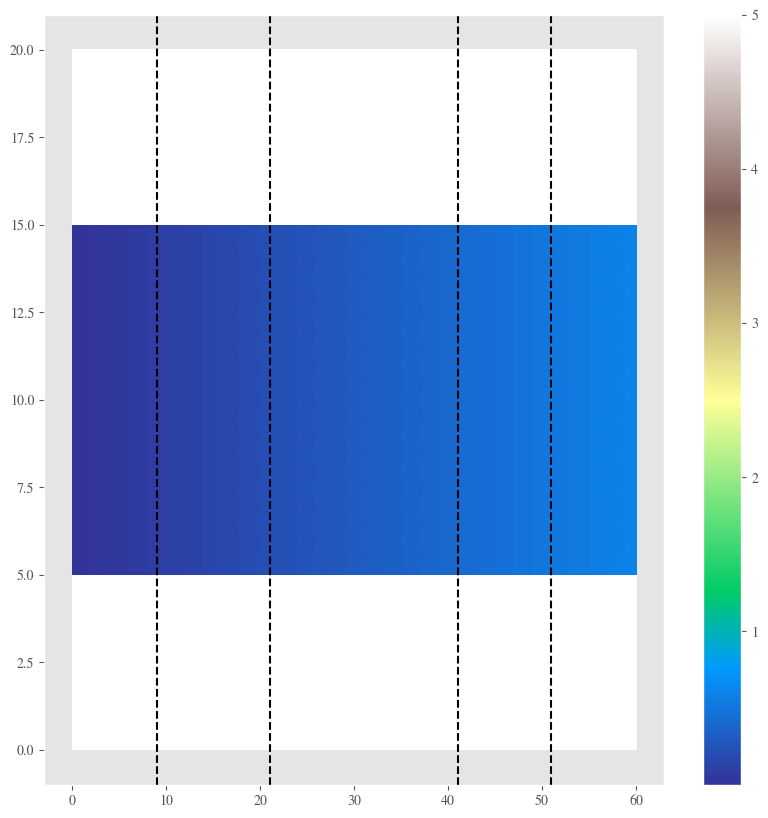

In [8]:
plt.figure(figsize=(10, 10))
dplotter = anuga.Domain_plotter(domain)
plt.tripcolor(dplotter.triang,
              facecolors = dplotter.elev,
            #   edgecolors='k',
              cmap='terrain')
plt.colorbar()
plt.axvline(x = 9, color = 'k',linestyle = '--', label = 'axvline - full height')
plt.axvline(x = 21, color = 'k',linestyle = '--', label = 'axvline - full height')
plt.axvline(x = 41, color = 'k',linestyle = '--', label = 'axvline - full height')
plt.axvline(x = 51, color = 'k',linestyle = '--', label = 'axvline - full height')

In [9]:
inlet1_anuga_inlet_op.inlet.get_total_water_volume()

-8.16

In [10]:
domain.output_frequency = 100
for t in domain.evolve(yieldstep=dt, outputstep=out_dt, finaltime=ft):
    #print('\n')
    print_out = domain.yieldstep_counter%domain.output_frequency == 0
    # print_out = False

    if print_out:
        domain.print_timestepping_statistics()

    anuga_depths = np.array([inlet1_anuga_inlet_op.inlet.get_average_depth(),
                             inlet2_anuga_inlet_op.inlet.get_average_depth(),
                             inlet3_anuga_inlet_op.inlet.get_average_depth(),
                             outlet_anuga_inlet_op.inlet.get_average_depth()])
    
    anuga_stages = np.array([inlet1_anuga_inlet_op.inlet.get_average_stage(),
                             inlet2_anuga_inlet_op.inlet.get_average_stage(),
                             inlet3_anuga_inlet_op.inlet.get_average_stage(),
                             outlet_anuga_inlet_op.inlet.get_average_stage()])


    # Compute the water volumes in the swmm model
    link_volume = swmm_culvert1.volume + swmm_culvert2.volume +swmm_culvert3.volume + swmm_outpipe.volume
    node_volume = 0.0
    sewer_volume = link_volume + node_volume

    # Compute anuga water volumes and boundary fluxes
    boundary_flux = domain.get_boundary_flux_integral()
    domain_volume = domain.get_water_volume()

    # Calculate correct and real volumes
    
    # total_volume_correct = baseline_flow * t + 0.5*baseline_flow + boundary_flux  + link_volume_0 - Links(sim)['Outpipe'].flow*dt
    total_volume_correct = (baseline_flow + baseline_flow2) * t + 0.5*(baseline_flow2 + baseline_flow) + boundary_flux  + link_volume_0 - Links(sim)['Outpipe'].flow*dt
    total_volume_real = domain_volume + sewer_volume
    correct_vols.append(total_volume_correct)
    real_vols.append(total_volume_real)

    loss = total_volume_real - total_volume_correct
    external_flows.append(system_routing.routing_stats['external_inflow'])

    

    # Append data for later plots
    domain_volumes.append(domain_volume)
    sewer_volumes.append(sewer_volume)
    time_series.append(t)
    losses.append(loss)
    conduit_depth_list.append(Links(sim)['Conduit1'].depth)
    conduit_depth_list.append(Links(sim)['Conduit2'].depth)
    conduit_depth_list.append(Links(sim)['Conduit3'].depth)

    anuga_ws.append(anuga_stages.copy())
    H_js.append([node.head for node in Nodes(sim) if node.is_junction()])
    

    # setup some aliases
    inlet1_head  = swmm_inlet1.head
    inlet2_head  = swmm_inlet2.head
    inlet3_head  = swmm_inlet3.head

    outlet_head = swmm_outlet.head
    outfall_head = swmm_outfall.head

    # inlet_invert = swmm_inlet1.invert_elevation
    # outlet_invert = swmm_outlet.invert_elevation
    # outfall_invert = swmm_outfall.invert_elevation


    if print_out:   
        print(40*'#') 
        print('    swmm/anuga time   :', sim.current_time, '/', t)
        print('    Loss              :', loss)
        print('    TV correct        :', total_volume_correct)
        print('    domain volume     :', domain.get_water_volume())
        print('    boundary flux     :', boundary_flux)
        print('    node_volume       :', node_volume)
        print('    sewer_volume      :', sewer_volume)
        print('    anuga_depths      :', anuga_depths)
        print('    anuga_beds        :', anuga_beds)
        print('    anuga_stages      :', anuga_stages)        

        for node in nodes:
            print(40*'*')
            print('   ', node.nodeid,' head         :', node.head)
            print('   ', node.nodeid,' invert elev  :', node.invert_elevation)
            print('   ', node.nodeid,' flooding     :', node.flooding)
            print('   ', node.nodeid,' depth        :', node.depth)
            print('   ', node.nodeid,' volume       :', node.volume)
            print('   ', node.nodeid,' surcharge    :', node.surcharge_depth)
            print('   ', node.nodeid,' lat inflow   :', node.lateral_inflow)
            print('   ', node.nodeid,' tot inflow   :', node.total_inflow)
            print('   ', node.nodeid,' tot outflow  :', node.total_outflow)
            print('   ', node.nodeid,' losses       :', node.losses)
            
        for link in links:
            print(40*'=')
            print('   ', link.linkid,' flow         :', link.flow)
            print('   ', link.linkid,' volume       :', link.volume)

    cumulative_inlet_flooding += swmm_inlet1.flooding*dt 
    cumulative_outlet_flooding += swmm_outlet.flooding*dt

    # Calculate the coupling flux and smooth to response
    node_heads = np.array([inlet1_head, inlet2_head, inlet3_head, outlet_head])

    inlet_volumes = [inlet1_anuga_inlet_op.inlet.get_total_water_volume(),inlet2_anuga_inlet_op.inlet.get_total_water_volume(),inlet3_anuga_inlet_op.inlet.get_total_water_volume(), outlet_anuga_inlet_op.inlet.get_total_water_volume()]
    # Q_in     = calculate_Q(node_heads, anuga_depths, anuga_beds, anuga_length_weirs, anuga_area_manholes, cw = cw, co = co)
    Q_in     = calculate_Q_v2(node_heads, anuga_depths, anuga_beds, anuga_length_weirs, anuga_area_manholes, inlet_volumes = inlet_volumes, dt = dt, cw = cw, co = co)

    Q_in     = 1.0*((time_average - dt)*Q_in_old + dt*Q_in)/time_average
    Q_in_old = Q_in
    Q_ins.append(Q_in.copy())
    Q_in_cumu += sum(Q_in)
    Q_in_cumus.append(Q_in_cumu)

    if print_out:
        print('    Calculated Q     ', Q_in[0], Q_in[1]) 

    # Run SWMM for a time of dt sewer using the calculated coupling fluxes
    swmm_inlet1.generated_inflow(Q_in[0])
    swmm_inlet2.generated_inflow(Q_in[1])
    swmm_inlet3.generated_inflow(Q_in[2])
    swmm_outlet.generated_inflow(Q_in[3])
    sim.step_advance(dt)
    sim.next()

    # Determine how much actually flowed into 1D model
    inlet1_vol = - swmm_inlet1.statistics['lateral_infow_vol'] + swmm_inlet1.statistics['flooding_volume']
    inlet1_flow = (inlet1_vol - old_inlet1_vol)/dt
    old_inlet1_vol = inlet1_vol
    
    inlet2_vol = - swmm_inlet2.statistics['lateral_infow_vol'] + swmm_inlet2.statistics['flooding_volume'] 
    inlet2_flow = (inlet2_vol - old_inlet2_vol)/dt
    old_inlet2_vol = inlet2_vol

    inlet3_vol = - swmm_inlet3.statistics['lateral_infow_vol'] + swmm_inlet3.statistics['flooding_volume'] 
    inlet3_flow = (inlet3_vol - old_inlet3_vol)/dt
    old_inlet3_vol = inlet3_vol

    outlet_vol = - swmm_outlet.statistics['lateral_infow_vol'] + swmm_outlet.statistics['flooding_volume'] 
    outlet_flow = (outlet_vol - old_outlet_vol)/dt
    old_outlet_vol = outlet_vol

    inlet_flows.append(inlet1_flow)
    outlet_flows.append(outlet_flow)


    inlet1_flood      = swmm_inlet1.statistics['flooding_volume']
    inlet1_flood_flow = (inlet1_flood-old_inlet1_flood)/dt
    old_inlet1_flood  = inlet1_flood
    inlet1_flood_flows.append(inlet1_flood_flow)


    inlet2_flood      = swmm_inlet2.statistics['flooding_volume']
    inlet2_flood_flow = (inlet2_flood-old_inlet2_flood)/dt
    old_inlet2_flood  = inlet2_flood

    inlet3_flood      = swmm_inlet3.statistics['flooding_volume']
    inlet3_flood_flow = (inlet3_flood-old_inlet3_flood)/dt
    old_inlet3_flood  = inlet3_flood

    outlet_flood      = swmm_outlet.statistics['flooding_volume']
    outlet_flood_flow = (outlet_flood-old_outlet_flood)/dt
    old_outlet_flood  = outlet_flood
    outlet_flood_flows.append(outlet_flood_flow)

    inlet_flood_vol.append(swmm_inlet1.statistics['flooding_volume'])
    inlet_lateral_vol.append(swmm_inlet1.statistics['lateral_infow_vol'])

    outlet_flood_vol.append(swmm_outlet.statistics['flooding_volume'])
    outlet_lateral_vol.append(swmm_outlet.statistics['lateral_infow_vol'])

    cumulative_inlet_flow += inlet1_flow*dt
    cumulative_outlet_flow += outlet_flow*dt



    # And consequently set anuga coupling Inlet_operators with actual SWMM fluxes
    # inlet1_anuga_inlet_op.set_Q(inlet1_flood_flow - Q_in[0])
    # inlet2_anuga_inlet_op.set_Q(inlet2_flood_flow - Q_in[1])
    # inlet3_anuga_inlet_op.set_Q(inlet3_flood_flow - Q_in[2])
    # outlet_anuga_inlet_op.set_Q(outlet_flood_flow + swmm_outfall.total_inflow - Q_in[3])

    inlet1_anuga_inlet_op.set_Q(inlet1_flow + baseline_flow)
    inlet2_anuga_inlet_op.set_Q(inlet2_flow)
    inlet3_anuga_inlet_op.set_Q(inlet3_flow)
    outlet_anuga_inlet_op.set_Q(outlet_flow + swmm_outfall.total_inflow)

    

print('Cumulative inlet flooding', cumulative_inlet_flooding)
print('Cumulative outlet flooding', cumulative_outlet_flooding)


print('anuga inlet applied volume ',inlet1_anuga_inlet_op.get_total_applied_volume())
print('anuga inlet cumulative flow', cumulative_inlet_flow)
print('swmm inlet lateral flow', swmm_inlet1.statistics['lateral_infow_vol'])
print('swmm inlet flooding vol', swmm_inlet1.statistics['flooding_volume'])
print('swmm inlet vol', swmm_inlet1.statistics['lateral_infow_vol'] - swmm_inlet1.statistics['flooding_volume'])


print('anuga outlet applied volume ',outlet_anuga_inlet_op.get_total_applied_volume())
print('anuga outlet Cumulative flow', cumulative_outlet_flow)
print('swmm outlet lateral flow', swmm_outlet.statistics['lateral_infow_vol'])
print('swmm outlet flooding vol', swmm_outlet.statistics['flooding_volume'])
print('swmm outlet vol', swmm_outlet.statistics['lateral_infow_vol'] - swmm_outlet.statistics['flooding_volume'])




# sim.close()


Time = 0.0000 (sec), steps=0 (1s)
########################################
    swmm/anuga time   : 1970-01-01 00:00:00 / 0.0
    Loss              : -0.25
    TV correct        : 0.2501320337138166
    domain volume     : 0.0
    boundary flux     : 0.0
    node_volume       : 0.0
    sewer_volume      : 0.0001320337138166011
    anuga_depths      : [0. 0. 0. 0.]
    anuga_beds        : [0.51 0.51 0.51 0.09]
    anuga_stages      : [0.51 0.51 0.51 0.09]
****************************************
    Inlet1  head         : 0.07
    Inlet1  invert elev  : 0.07
    Inlet1  flooding     : 0.0
    Inlet1  depth        : 0.0
    Inlet1  volume       : 0.0
    Inlet1  surcharge    : 0.15
    Inlet1  lat inflow   : 0.0
    Inlet1  tot inflow   : 0.0
    Inlet1  tot outflow  : 0.0
    Inlet1  losses       : 0.0
****************************************
    Outlet  head         : 0.03
    Outlet  invert elev  : 0.03
    Outlet  flooding     : 0.0
    Outlet  depth        : 0.0
    Outlet  volume   

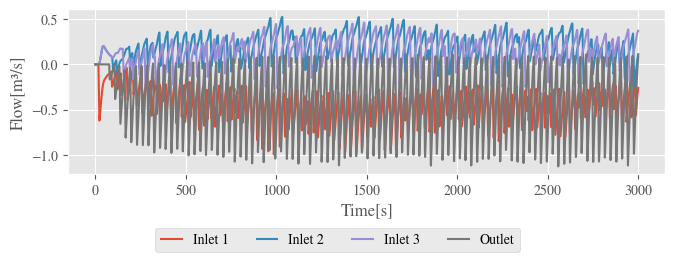

In [11]:

inch = 2.54
fig_size = 17
# fig_size = 34

fig_size = fig_size/inch
fig_aspect = 3
fig, ax = plt.subplots(1,1)
fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)

ax.plot(Q_ins,label = ['Inlet 1' , 'Inlet 2', 'Inlet 3', 'Outlet'])
ax.set_xlabel('Time[s]')
ax.set_ylabel('Flow[m³/s]')
fig.tight_layout(pad = .5)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5,-0.15),handlelength=1.5,ncol=5)

When pipe is filled it starts to flood

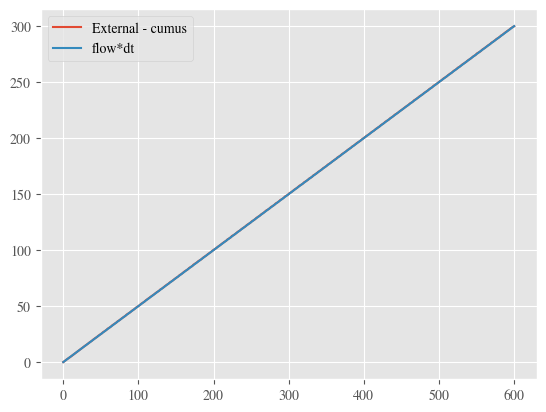

In [12]:
plt.plot(time_series, external_flows-np.array(Q_in_cumus)*dt,label = 'External - cumus')
plt.plot(time_series, baseline_flow*np.array(time_series),label = 'flow*dt')

plt.legend()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


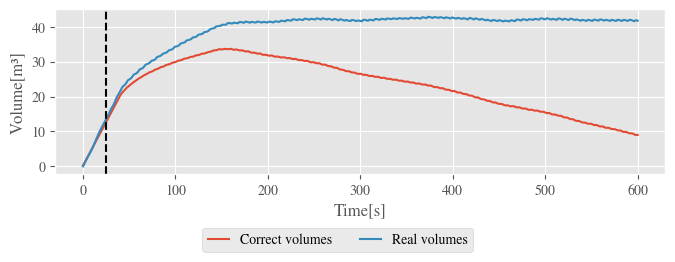

In [16]:


inch = 2.54
fig_size = 17
# fig_size = 34

fig_size = fig_size/inch
fig_aspect = 3
fig, ax = plt.subplots(1,1)
fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)

# ax.axvline(65,color = 'k',linestyle = '--')
ax.plot(time_series,correct_vols,label = 'Correct volumes')
ax.plot(time_series,real_vols, label = 'Real volumes')
ax.axvline(25, color = 'k' , linestyle = '--')
ax.set_xlabel('Time[s]')
ax.set_ylabel('Volume[m³]')
# ax2 = ax.twinx()
# ax2.plot(time_series,conduit_depth_list,color = 'C5')
# ax2.set_ylabel('Conduit depth[m]')
# ax2.yaxis.label.set_color(ax2.get_lines()[0].get_color())

# ax2.grid(False)


fig.tight_layout(pad = .5)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5,-0.15),handlelength=1.5,ncol=5)
if True:
    # plt.savefig(plot_path +'vol_vs_method_' + plotname + '.eps',format = 'eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig('plots/mass_convservatio_3inlet_large_inlet_lat_base' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.eps', bbox_inches='tight')
    plt.savefig('plots/mass_convservation_3inlet_large_inlet_lat_base' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.png', bbox_inches='tight')


In [14]:
# inch = 2.54
# fig_size = 17
# # fig_size = 34

# fig_size = fig_size/inch
# fig_aspect = 3
# fig, ax = plt.subplots(1,1)
# fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)

# # ax.axvline(65,color = 'k',linestyle = '--')
# ax.plot(time_series,conduit_depth_list)
# ax.set_ylabel('Conduit depth[m]')
# ax.axvline(55, color = 'k' , linestyle = '--')

# ax.set_xlabel('Time[s]')


# fig.tight_layout(pad = .5)
# # handles, labels = ax.get_legend_handles_labels()
# lgd = fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5,-0.15),handlelength=1.5,ncol=5)

ValueError: x and y must have same first dimension, but have shapes (3001,) and (9003,)

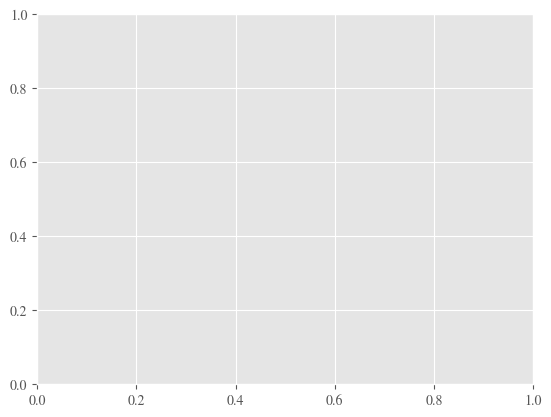

In [15]:
plt.plot(time_series,conduit_depth_list)
plt.axvline(55, color = 'k' , linestyle = '--')


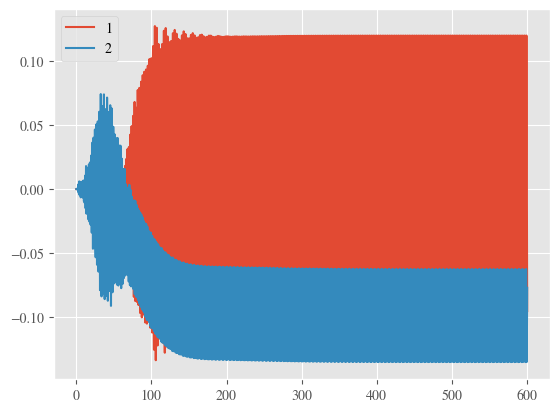

In [ ]:
plt.plot(time_series,Q_ins,label = ['1','2'])
plt.legend()

In [ ]:
sewer_volume

8.20990765983148

In [ ]:
boundary_flux

-47.26797122652912

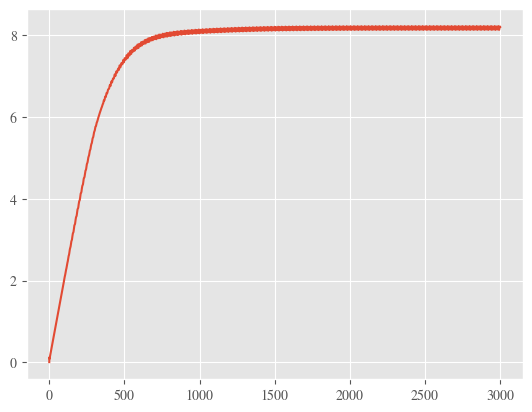

In [ ]:
plt.plot(sewer_volumes)

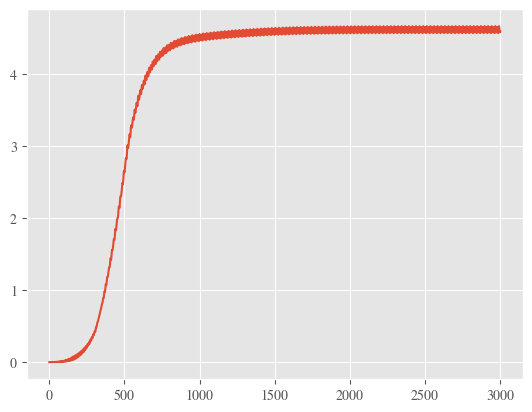

In [ ]:
plt.plot(domain_volumes)

In [ ]:
inlet_lateral_vol_array = np.array(inlet_lateral_vol)
inlet_lateral_vol_array = np.insert(inlet_lateral_vol_array,0,np.array([0,0,0,0]),axis = 0)
lateral_inflows = (inlet_lateral_vol_array[1:]-inlet_lateral_vol_array[0:-1])/dt

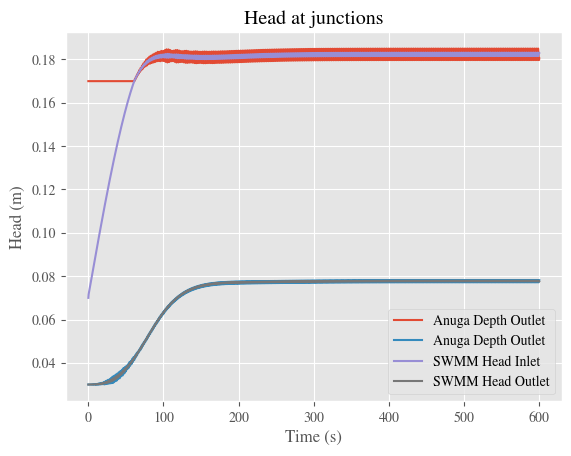

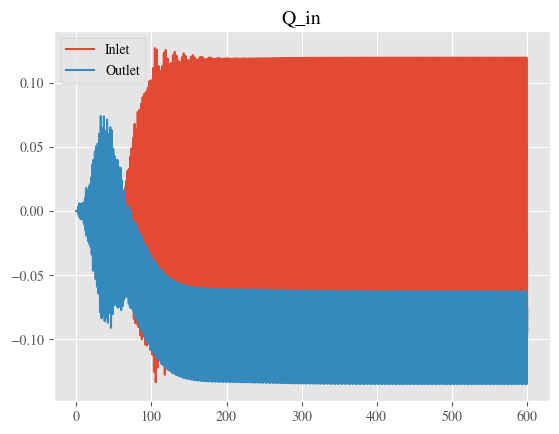

In [ ]:
if visualise:
    H_j = np.vstack(H_js)
    anuga_j = np.vstack(anuga_ws)
    Q_ins = np.vstack(Q_ins)

    plt.ion()

    plt.figure(1)
    # plt.plot(time_series, anuga_j[:,0], linestyle = '-',label='Anuga Inlet 0')
    # plt.plot(time_series, anuga_j[:,1], linestyle = '-', label='Anuga Inlet 1')
    # plt.plot(time_series, H_j[:,0], label='Pipe Inlet 0')
    # plt.plot(time_series, H_j[:,1], label='Pipe Inlet 1')
    plt.plot(time_series, anuga_j[:,0], linestyle = '-',label='Anuga Depth Outlet')
    plt.plot(time_series, anuga_j[:,1], linestyle = '-', label='Anuga Depth Outlet')
    plt.plot(time_series, H_j[:,0], label='SWMM Head Inlet')
    plt.plot(time_series, H_j[:,1], label='SWMM Head Outlet')

    # plt.plot([time_series[0], time_series[-1]],2*[inp.junctions.Max_Depth.values[0] + inp.junctions.Surcharge_Depth.values[0]])

    plt.legend()
    plt.title('Head at junctions')
    plt.xlabel('Time (s)')
    plt.ylabel('Head (m)')
    # plt.savefig('Figure1.png')
    plt.show()

    # plt.figure(2)
    # plt.clf()
    # plt.plot(time_series, losses)
    # plt.title('Losses')
    # plt.savefig('Figure2.png')
    # plt.show()

    # plt.figure(3)
    # plt.clf()
    # plt.plot(time_series, Q_dks)
    # plt.title('Q_dks')
    # plt.savefig('Figure3.png')
    # plt.show()

    plt.figure(4)
    plt.clf()
    plt.plot(time_series, Q_ins[:,0], label='Inlet')
    plt.plot(time_series, Q_ins[:,1], label='Outlet')
    plt.legend()
    plt.title('Q_in')
    # plt.savefig('Figure4.png')
    plt.show()

In [ ]:
np.cumsum(Q_ins,axis = 0)[-1,:]

array([  -2.02238506, -254.5871414 ])

In [ ]:
np.sum(np.cumsum(Q_ins,axis = 0),axis = 1)

array([ 0.00000000e+00, -1.56440239e-04, -3.09720680e-04, ...,
       -2.56284666e+02, -2.56437338e+02, -2.56609526e+02])

In [ ]:
np.cumsum(Q_ins)

array([   0.        ,    0.        ,    0.        , ..., -256.43733758,
       -256.53247669, -256.60952646])

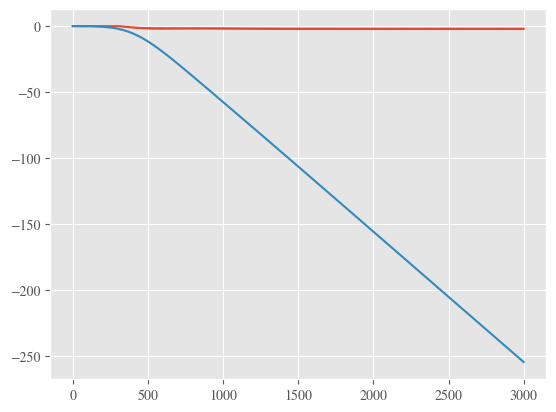

In [ ]:
# plt.plot(Q_ins)
plt.plot(np.cumsum(Q_ins,axis = 0))

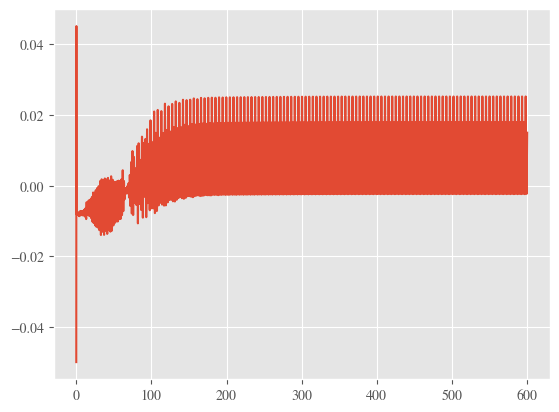

In [ ]:
plt.plot(time_series,losses)

In [ ]:
(losses[-1]-losses[100])/(time_series[-1]-time_series[100])

4.176139699611369e-05

In [ ]:
loss

0.014994934086098866

In [ ]:
sum(Q_ins)

array([  -2.02238506, -254.5871414 ])